In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import calendar


import seaborn as sns
import matplotlib.pyplot as plt   
from matplotlib.pyplot import pie
from matplotlib import gridspec
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings('ignore')

import scipy.stats
from scipy.stats import norm, chi2
import os

In [79]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [80]:
import yfinance as yf

In [81]:
#define the ticker symbol
tickerSymbol = 'ETH-USD'

In [82]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

In [83]:
#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2015-9-1', end='2021-10-1')

In [84]:
tickerDf = tickerDf[['Close']]

In [85]:
tickerDf.tail()

,Close
Date,
2021-09-27,2934.138916
2021-09-28,2807.296631
2021-09-29,2853.143311
2021-09-30,3001.678955
2021-10-01,3307.516113


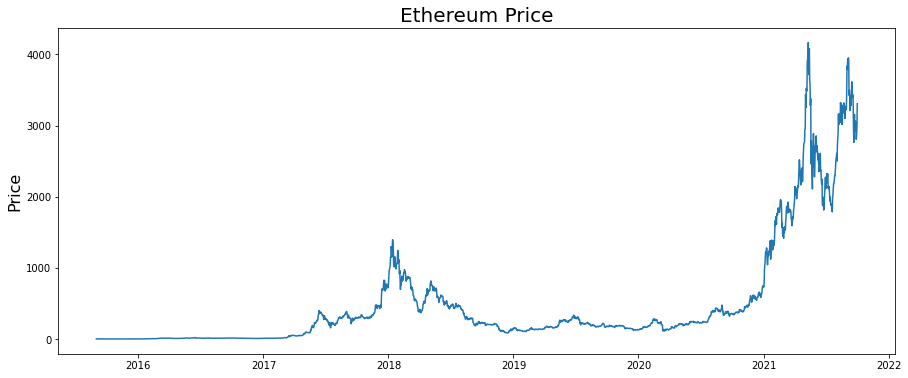

In [86]:
plt.figure(figsize=(15,6))
plt.plot(tickerDf['Close'], label='Ethereum')
plt.title('Ethereum Price', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.show()

In [87]:
tickerDf['logged'] = np.log(tickerDf['Close'])

In [88]:
tickerDf.tail()

,Close,logged
Date,,
2021-09-27,2934.138916,7.984169
2021-09-28,2807.296631,7.939977
2021-09-29,2853.143311,7.956177
2021-09-30,3001.678955,8.006927
2021-10-01,3307.516113,8.103953


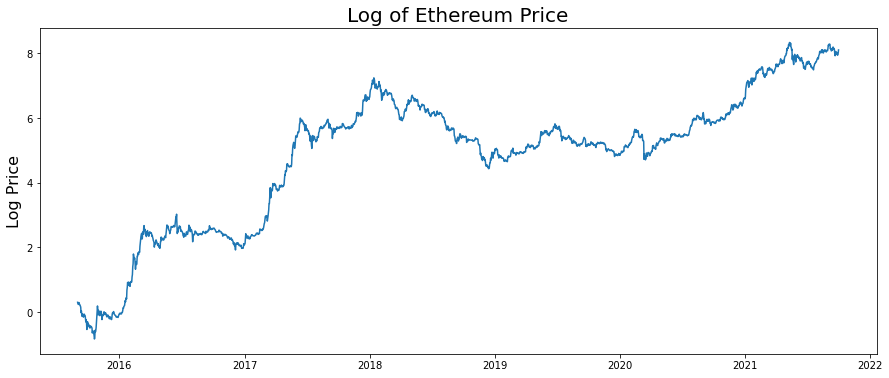

In [89]:
plt.figure(figsize=(15,6))
plt.plot(tickerDf['logged'], label='Ethereum')
plt.title('Log of Ethereum Price', fontsize=20)
plt.ylabel('Log Price', fontsize=16)
plt.show()

In [90]:
def turningpoints(x):
    N=0
    for i in range(1, len(x)-1):
        if ((x[i-1] < x[i] and x[i+1] < x[i]) or (x[i-1] > x[i] and x[i+1] > x[i])):
            N += 1
    return N


t = turningpoints(tickerDf['logged'])
expectatoion = ((2*tickerDf.shape[0]) - 4) / 3
variance = ((16*tickerDf.shape[0]) - 29) / 90
z_score = (t - expectatoion) / (variance**0.5)
print("z-score = ",z_score)
p_value = scipy.stats.norm.sf(abs(z_score))*2
print("p-value = ",p_value)# p<0.05 so null hypothesis is rejected at 5% level of significance. i.e. the the time series is not random.

z-score =  -15.16095463533037
p-value =  6.413038368338921e-52


In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose

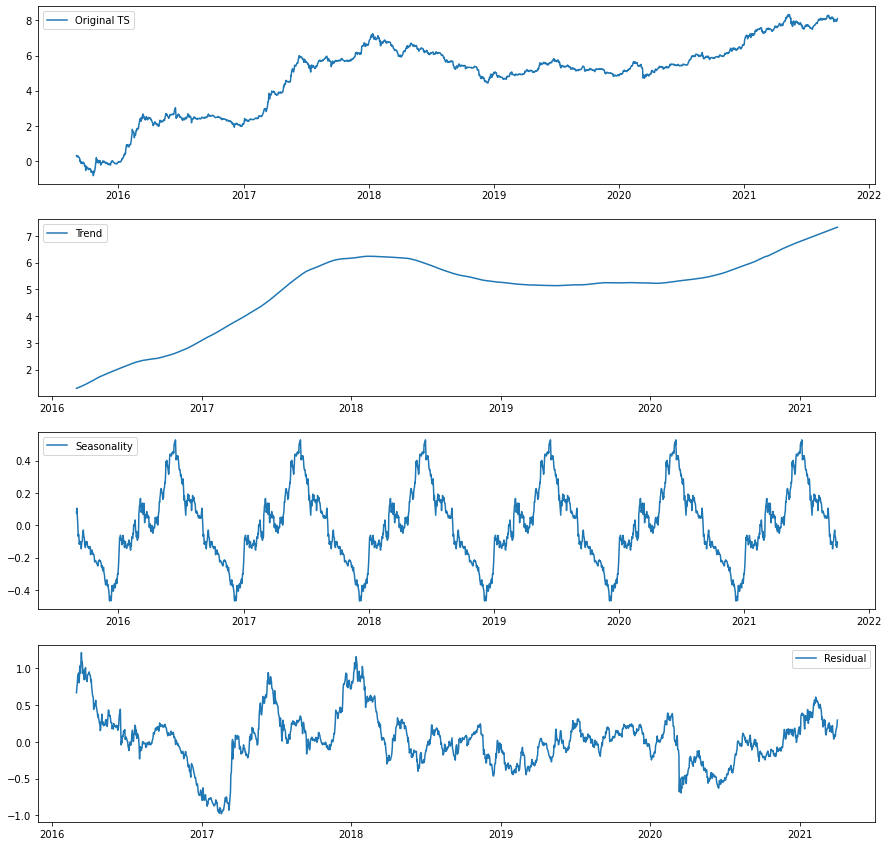

In [92]:
decompose_add=seasonal_decompose(tickerDf['logged'], model='additive', period=365)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(tickerDf['logged'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

In [93]:
def relative_ordering(temp,alpha):
    Q = 0
    n = len(temp)
    for i in range(n):
        for j in range(i+1,n):
            if(temp[i] - temp[j] > 0):
                Q+=1
    print('Q = ',Q)
    T=1-4*Q/(n*(n-1))
    VT=2*(2*n+5)/(9*n*(n-1))
    Z=T/(VT**0.5)
    t=norm.ppf(1-alpha/2)
    print('Z = ',Z)
    print('t_alpha/2 = ',t)
    if(abs(Z) <= t):
        print('So, Trend is not present')
    else:
        print('Trend is present')

In [94]:
temp=[float(i) for i in tickerDf['logged']]
relative_ordering(temp, 0.05)

Q =  534532
Z =  39.931689946114595
t_alpha/2 =  1.959963984540054
Trend is present


In [95]:
#take first difference
first_diffs = tickerDf.logged.values[1:] - tickerDf.logged.values[:-1]
first_diffs = np.concatenate([first_diffs, [0]])

In [96]:
#set first difference as variable in dataframe
tickerDf['FirstDifference'] = first_diffs

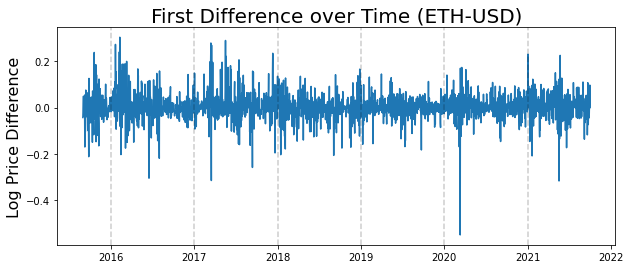

In [97]:
plt.figure(figsize=(10,4))
plt.plot(tickerDf.FirstDifference)
plt.title('First Difference over Time (%s)'%tickerSymbol, fontsize=20)
plt.ylabel('Log Price Difference', fontsize=16)
for year in range(2016,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [98]:
#Augmented Dicky-fuller test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(tickerDf['FirstDifference'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

## Data is stationary

ADF Statistic: -8.666656
p-value: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [99]:
temp=[float(i) for i in tickerDf['FirstDifference']]
relative_ordering(temp, 0.05)

Q =  1203633
Z =  1.5379562249374217
t_alpha/2 =  1.959963984540054
So, Trend is not present


In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

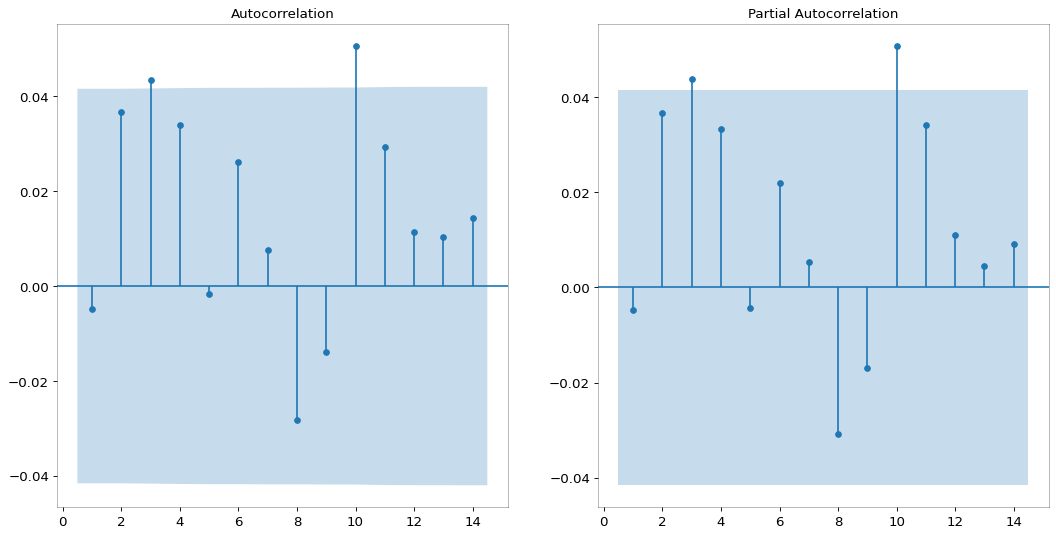

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8), dpi= 80)
acf_plot_diff = plot_acf(tickerDf.FirstDifference, ax=ax1, lags=np.arange(1,15))
pacf_plot_diff = plot_pacf(tickerDf.FirstDifference, ax=ax2, lags = np.arange(1,15), method='ols')
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)
# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [102]:
def test_stationary(timeseries):
    movingAvg=timeseries.rolling(window=365).mean()
    movingSTD=timeseries.rolling(window=365).std()
    #plotting rolling statistics
    orig=plt.plot(timeseries, color='aqua', label='original')
    mean=plt.plot(movingAvg, color='red', label='mean')
    std=plt.plot(movingSTD, color='black', label='std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

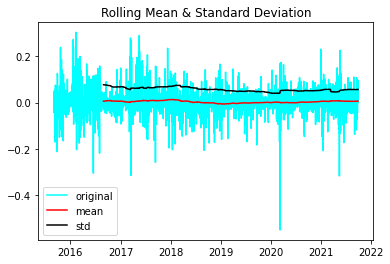

In [103]:
test_stationary(tickerDf['FirstDifference'])

In [104]:
from statsmodels.tsa.arima.model import ARIMA
AIC=[]
BIC=[]
for p in range(1,12):
    for q in range(1,12):
        model=ARIMA(tickerDf['FirstDifference'],order=(p,0,q))
        model_fit=model.fit()
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)

In [122]:
np.reshape(AIC,(11,11))

array([[-6178.84528552, -6188.89917047, -6183.93427292, -6182.30009313,
        -6180.36535621, -6179.35783608, -6178.00292116, -6175.87456098,
        -6176.87962181, -6182.08269755, -6180.02146027],
       [-6188.94891142, -6183.78046509, -6181.95126777, -6180.36897549,
        -6178.35900787, -6182.11283176, -6183.83380727, -6179.31634688,
        -6174.90791315, -6184.16601873, -6183.5795504 ],
       [-6182.11959424, -6181.63200581, -6179.95728771, -6182.44306713,
        -6180.51085493, -6178.65395723, -6181.59325382, -6177.79827773,
        -6170.64946589, -6181.54302553, -6182.0936314 ],
       [-6182.54122733, -6180.7435382 , -6182.84959296, -6178.76108913,
        -6182.18608252, -6176.35701332, -6174.55397996, -6178.13531345,
        -6173.05727344, -6178.66750224, -6180.00394311],
       [-6180.5857696 , -6182.75371658, -6179.89090186, -6177.64734598,
        -6174.93742931, -6175.14447458, -6172.44479848, -6176.48561281,
        -6176.1243217 , -6182.33856413, -6181.954501

In [106]:
print(np.where(x == x.min()))

(array([7]), array([10]))


In [107]:
np.reshape(BIC,(11,11))

array([[-6156.02603783, -6160.37511085, -6149.70540138, -6142.36640967,
        -6134.72686082, -6128.01452877, -6120.95480193, -6113.12162983,
        -6108.42187874, -6107.92014255, -6100.15409335],
       [-6160.42485181, -6149.55159355, -6142.01758431, -6134.7304801 ,
        -6127.01570056, -6125.06471253, -6121.08087612, -6110.85860381,
        -6100.74535815, -6104.29865181, -6098.00737156],
       [-6147.89072271, -6141.69832235, -6134.31879233, -6131.09975982,
        -6123.4627357 , -6115.90102608, -6113.13551074, -6103.63572273,
        -6090.78209897, -6095.97084669, -6090.81664063],
       [-6142.60754387, -6135.10504281, -6131.50628565, -6121.7129699 ,
        -6119.43315137, -6107.89927024, -6100.39142497, -6098.26794653,
        -6087.4850946 , -6087.39051147, -6083.02214042],
       [-6134.94727422, -6131.41040928, -6122.84278263, -6114.89441483,
        -6106.47968623, -6100.98191958, -6092.57743156, -6090.91343397,
        -6084.84733093, -6085.35676144, -6079.267886

In [124]:
final=ARIMA(tickerDf,order=(8,1,11))
final=final.fit()

In [125]:
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 logged   No. Observations:                 2219
Model:                ARIMA(8, 1, 11)   Log Likelihood                3112.687
Date:                Wed, 17 Nov 2021   AIC                          -6185.374
Time:                        02:16:28   BIC                          -6071.287
Sample:                             0   HQIC                         -6143.703
                               - 2219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3019      0.172     -1.754      0.080      -0.639       0.036
ar.L2          0.4448      0.147      3.031      0.002       0.157       0.732
ar.L3          0.3820      0.168      2.268      0.023       0.052       0.712
ar.L4          0.2759      0.182      1.517      0.129      -0.081       0.632
ar.L5          0.1886      0.179      1.052      0.293      -0.163       0.540
ar.L6          0.1981      0.163      1.214      0.225      -0.122       0.518
ar.L7         -0.0128      0.139     -0.092      0.927      -0.286       0.260
ar.L8         -0.4560      0.130     -3.506      0.000      -0.711      -0.201
ma.L1          0.2972      0.172      1.724      0.085      -0.041       0.635
ma.L2         -0.4112      0.149     -2.759      0.006      -0.703      -0.119
ma.L3         -0.3228      0.164     -1.963      0.050      -0.645      -0.001
ma.L4         -0.2564      0.181     -1.416      0.157      -0.611       0.098
ma.L5         -0.2211      0.175     -1.262      0.207      -0.565       0.122
ma.L6         -0.2052      0.159     -1.295      0.195      -0.516       0.105
ma.L7         -0.0148      0.135     -0.109      0.913      -0.280       0.251
ma.L8          0.4171      0.126      3.299      0.001       0.169       0.665
ma.L9         -0.0587      0.023     -2.532      0.011      -0.104      -0.013
ma.L10         0.0873      0.023      3.847      0.000       0.043       0.132
ma.L11         0.0932      0.027      3.467      0.001       0.041       0.146
sigma2         0.0035   5.91e-05     59.745      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3997.82
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
pred=final.predict()

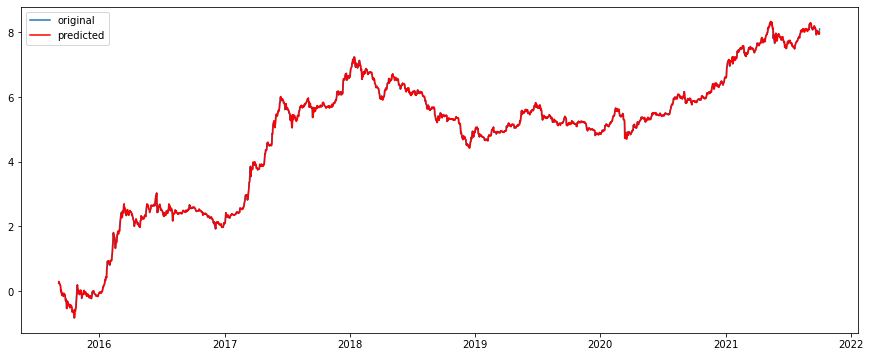

In [127]:
plt.figure(figsize=(15,6))
plt.plot(tickerDf[4:] , label='original')
plt.plot(pred[4:], color='red', label='predicted')
plt.legend(loc='best', prop={'size': 10})
plt.show()

In [128]:
forecast= final.forecast(steps=10)
forecast

2219    8.105358
2220    8.115314
2221    8.112732
2222    8.108238
2223    8.107634
2224    8.106199
2225    8.100470
2226    8.094526
2227    8.091902
2228    8.097686
Name: predicted_mean, dtype: float64

In [129]:
import math
forecast_data = list(forecast)
forecast_data1 = []
for ele in forecast_data:
    forecast_data1.append(math.exp(ele))

In [130]:
for ele in forecast_data1:
    print(ele)

3312.1669098132747
3345.309455990676
3336.680254911625
3321.7200143952005
3319.713968019474
3314.9542023633553
3296.016329827274
3276.4829813090882
3267.8972047825905
3286.8524687978957


In [131]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

In [132]:
org = tickerData.history(period='1d', start='2021-10-1', end='2021-10-10')

In [133]:
org_data = list(org['Close'])

In [134]:
org_data

[3307.51611328125,
 3391.6943359375,
 3418.358642578125,
 3380.089111328125,
 3518.5185546875,
 3580.56201171875,
 3587.974853515625,
 3563.75927734375,
 3575.716796875,
 3425.852783203125]

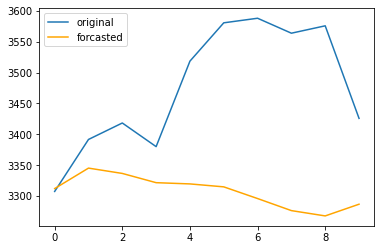

In [135]:
plt.plot(org_data , label='original')
plt.plot(forecast_data1, color='orange', label='forcasted')
plt.legend(loc='best', prop={'size': 10})
plt.show()

In [136]:
mean_absolute_percentage_error(org_data, forecast_data1)

4.755694460288888